In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # 第一个卷积层， 输入图像通道为3 , 输出的通道数为64 , 卷积核大小为3x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2)
        
        # 第二个卷积层， 输入通道数为64 , 输出的通道数为128 , 卷积核大小为3x3
        self.conv2 = nn.Conv2d(64, 128, 3)
        
        # 第三个卷积层， 输入通道数为16 , 输出的通道数为3256 , 卷积核大小为3x3
        self.conv3 = nn.Conv2d(128, 256, 3)
        
        # 第一个全连接层
        self.fc1 = nn.Linear(256*12*12, 256)
        
        # 第二个全连接层
        self.fc2 = nn.Linear(256, 128)
        
        # 最后的全连接层，输出为2代表2分类
        self.fc3 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2,2))
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2,2))
        
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2,2))
        
        # 将卷积后的二维的特征图展开为一维向量用于全连接层的输入
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
        
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()
net.cuda()
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=36864, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


In [3]:
### 数据载入
plt.ion()

data_transforms = {
    # 训练中的数据增强和归一化
    'train':transforms.Compose([
        # 随机裁剪
        transforms.RandomResizedCrop(224),
        # 左右翻转
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # 验证集不增强，仅进行归一化
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = r'C:\Users\ThinkPad\Desktop\hymenoptera_data\\'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {
    x:torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                  shuffle=True, num_workers=4)
    for x in ['train', 'val']}

dataset_size = {x:len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torch.Size([4, 3, 224, 224]) --> torch.Size([4])


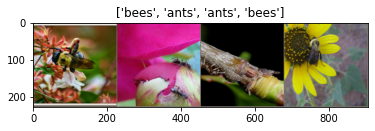

In [4]:
def imshow(inp, title=None):
    # 将输入的类型为torch.tensor的图像数据转为numpy的ndarray格式
    # 由于每个batch的数据是先经过transforms.ToTensor()函数从numpy的ndarray格式转换为torch.tensor格式，这个转换主要是通道顺序上做了调整：
    # 由原始的numpy中的BGR顺序转换为torch中的RGB顺序
    # 所以我们在可视化时候，要先将通道的顺序转换回来，即从RGB转回BGR
    inp = inp.numpy().transpose((1,2,0))
    # 接着再进行反归一化
    mean = np.array([[0.485, 0.456, 0.406]])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dataloaders['train'])) 
print(inputs.shape,'-->', classes.shape)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [5]:
# 模型训练
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        
        # 每一个epoch都会进行一次验证
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() #设置模型为训练模型
            else:
                model.eval() #设置模型为验证模型
                
            running_loss = 0.0
            running_corrects = 0
            
            # 迭代所有样本
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 将梯度置零
                optimizer.zero_grad()
                
                # 前向传播网络，仅在训练状态记录参数的梯度从而计算loss
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # 方向传播 梯度下降
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # 统计loss值
                running_loss += loss.item()* inputs.size(0)
                running_corrects +=torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4}'.format(
                phase, epoch_loss, epoch_acc))
                
            # 依据验证集的准确率来更新最优模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 载入最优模型
    model.load_state_dict(best_model_wts)
    return model
                            

In [6]:
# 定义分类loss 
criterion = nn.CrossEntropyLoss()

# 优化器使用sgd，学习率设置为0.001
optimizer_ft = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 每7个epoch 将lr 降低为原来的 0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
cnn_model = train_model(net, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6953 Acc: 0.4571
val Loss: 0.6893 Acc: 0.5686

Epoch 1/24
----------
train Loss: 0.6908 Acc: 0.5102
val Loss: 0.6841 Acc: 0.5817

Epoch 2/24
----------
train Loss: 0.6867 Acc: 0.5592
val Loss: 0.6783 Acc: 0.5752

Epoch 3/24
----------
train Loss: 0.6830 Acc: 0.5592
val Loss: 0.6739 Acc: 0.5621

Epoch 4/24
----------
train Loss: 0.6782 Acc: 0.5633
val Loss: 0.6690 Acc: 0.5752

Epoch 5/24
----------
train Loss: 0.6764 Acc: 0.5796
val Loss: 0.6713 Acc: 0.5621

Epoch 6/24
----------
train Loss: 0.6589 Acc: 0.5673
val Loss: 0.6686 Acc: 0.5817

Epoch 7/24
----------
train Loss: 0.6446 Acc: 0.6163
val Loss: 0.6646 Acc: 0.5882

Epoch 8/24
----------
train Loss: 0.6386 Acc: 0.649
val Loss: 0.6635 Acc: 0.5882

Epoch 9/24
----------
train Loss: 0.6370 Acc: 0.6204
val Loss: 0.6621 Acc: 0.6078

Epoch 10/24
----------
train Loss: 0.6331 Acc: 0.6245
val Loss: 0.6598 Acc: 0.6144

Epoch 11/24
----------
train Loss: 0.6306 Acc: 0.6163
val Loss: 0.6608 Acc: 0.6078

Epo

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

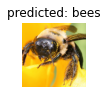

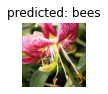

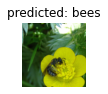

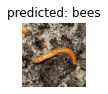

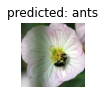

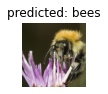

In [8]:
visualize_model(cnn_model)

In [9]:
# 从torchvision中载入resnet18模型，并且加载预训练
model_conv = torchvision.models.resnet18(pretrained=True)
# freeze前面的卷积层，使其训练时不更新
for param in model_conv.parameters():
    param.requires_grad = False

# 最后的分类fc层输出换为2，进行二分类
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 仅训练最后改变的fc层
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
model_ft = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=25) 



Epoch 0/24
----------
train Loss: 0.6026 Acc: 0.6245
val Loss: 0.1954 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.5603 Acc: 0.7265
val Loss: 0.2460 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4719 Acc: 0.8041
val Loss: 0.2245 Acc: 0.915

Epoch 3/24
----------
train Loss: 0.6122 Acc: 0.7551
val Loss: 0.1746 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.7020 Acc: 0.7837
val Loss: 0.1838 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4709 Acc: 0.7959
val Loss: 0.2017 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4726 Acc: 0.8286
val Loss: 0.1967 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4046 Acc: 0.8449
val Loss: 0.1968 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3605 Acc: 0.8327
val Loss: 0.2109 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.4014 Acc: 0.8367
val Loss: 0.1848 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3469 Acc: 0.8367
val Loss: 0.2073 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3684 Acc: 0.8612
val Loss: 0.2525 Acc: 0.915

Epoc

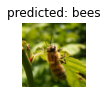

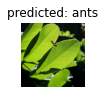

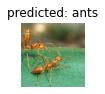

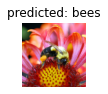

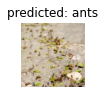

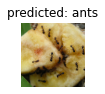

In [11]:
visualize_model(model_ft)

plt.ioff()
plt.show()